# **Heart Disease Prediction Using XAI**

In [2]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=52d9af5111a4b35e7572a8d7bad467516fd542a27057a00b3fbf1d7edefb5c40
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


# **Importing Libraries**

In [46]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, r2_score, accuracy_score,precision_score, recall_score
from lime import lime_tabular
import plotly.express as px
import plotly.graph_objects as go

# **Importing Data**

In [2]:
from google.colab import files
uploaded = files.upload()


Saving heart.csv to heart (4).csv


In [3]:
heart = list(uploaded.keys())[0]
df = pd.read_csv(heart)

# df.head()
df.sample(5)



age  sex   cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
2072   29  1.0  3.0       110   281  0.0      1.0      123    0.0      0.7   
2557   62  1.0  0.0       143   238  0.0      0.0      122    0.0      3.1   
3520   67  1.0  1.0       102   230  0.0      1.0      153    0.0      0.9   
1301   63  0.0  0.0       150   407  0.0      0.0      154    0.0      4.0   
1702   68  1.0  2.0       180   274  1.0      0.0      150    1.0      1.6   

      slope   ca  thal  target  
2072    1.0  3.0   3.0     0.0  
2557    1.0  0.0   3.0     0.0  
3520    0.0  0.0   3.0     0.0  
1301    1.0  3.0   3.0     0.0  
1702    1.0  0.0   3.0     0.0

# **Data Cleaning**

**Removing Duplicates**

In [4]:

df_cleaned = df.drop_duplicates()


print("Number of duplicates removed:", df.shape[0] - df_cleaned.shape[0])

Number of duplicates removed: 1698


Fixing Structural Errors

In [5]:


valid_categories = {
    'sex': [0, 1],
    'cp': [0, 1, 2, 3],
    'fbs': [0, 1],
    'restecg': [0, 1, 2],
    'exang': [0, 1],
    'slope': [0, 1, 2],
    'thal': [0, 1, 2, 3],
    'target': [0, 1]
}

for col, valid_vals in valid_categories.items():
    df_cleaned = df_cleaned[df_cleaned[col].isin(valid_vals)]



Filtering Unwanted Outliers

In [6]:


def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers for selected numerical columns
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df_cleaned = remove_outliers(df_cleaned, numerical_cols)


Handling Missing Data

In [7]:

print("Missing values before handling:")
print(df_cleaned.isnull().sum())

df_cleaned.fillna(df_cleaned.median(), inplace=True)

categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'target']
for col in categorical_cols:
    df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

print("Missing values after handling:")
print(df_cleaned.isnull().sum())


Missing values before handling:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
Missing values after handling:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


<ipython-input-7-92458117bb8f>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)


Validation and Quality Assurance

In [8]:

assert (df_cleaned[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']] >= 0).all().all(), "Negative values found!"

for col, valid_vals in valid_categories.items():
    assert set(df_cleaned[col].unique()).issubset(valid_vals), f"Invalid values found in {col}!"

assert set(df_cleaned['target'].unique()) == {0, 1}, "Target variable should only contain 0 and 1."

print("Final cleaned dataset shape:", df_cleaned.shape)



Final cleaned dataset shape: (2158, 14)


In [9]:
df_cleaned.to_csv('heart_cleaned.csv', index=False)

from google.colab import files
files.download('heart_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Loading the Cleaned Dataset**

In [9]:
from google.colab import files
uploaded = files.upload()

Saving heart_cleaned.csv to heart_cleaned (4).csv


In [10]:
heart_cleaned = list(uploaded.keys())[0]
data = pd.read_csv(heart_cleaned)

# df.head()
data.sample(5)

age  sex   cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
375    74  0.0  1.0       126   320  0.0      1.0      173    0.0      0.0   
617    57  0.0  0.0       140   235  0.0      0.0      162    0.0      0.1   
128    41  1.0  1.0       110   235  0.0      1.0      153    0.0      0.0   
1080   60  1.0  0.0       136   324  0.0      1.0      125    1.0      1.7   
1099   41  1.0  0.0       118   239  0.0      0.0      148    0.0      0.5   

      slope   ca  thal  target  
375     2.0  1.0   2.0     1.0  
617     2.0  3.0   2.0     1.0  
128     2.0  0.0   2.0     1.0  
1080    1.0  4.0   1.0     0.0  
1099    2.0  4.0   1.0     0.0

# **Data Visualation**

Histogram for Age Distribution

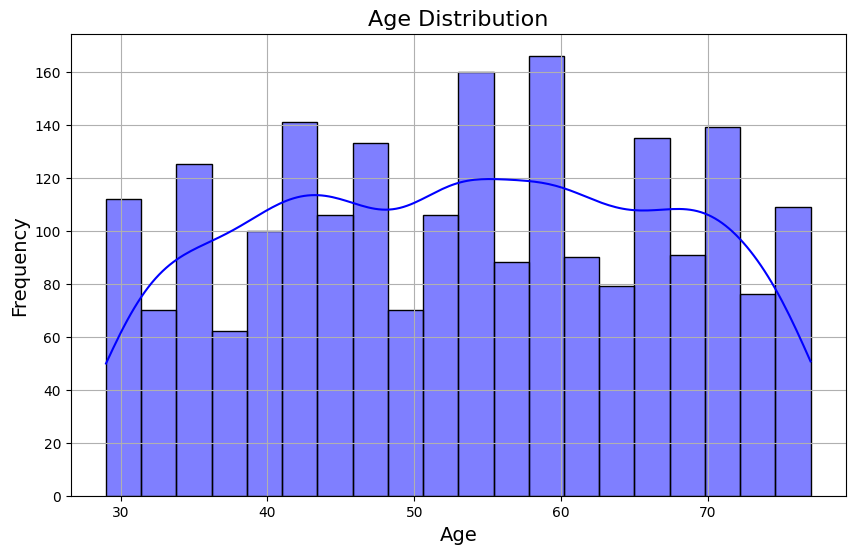

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], kde=True, color='blue', bins=20)  # kde=True adds a smooth curve to the histogram
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

Bar Chart

<ipython-input-12-4762ae2e942e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sex', data=df_cleaned, palette='Set2')
<ipython-input-12-4762ae2e942e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cp', data=df_cleaned, palette='Set2')
<ipython-input-12-4762ae2e942e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df_cleaned, palette='Set2')


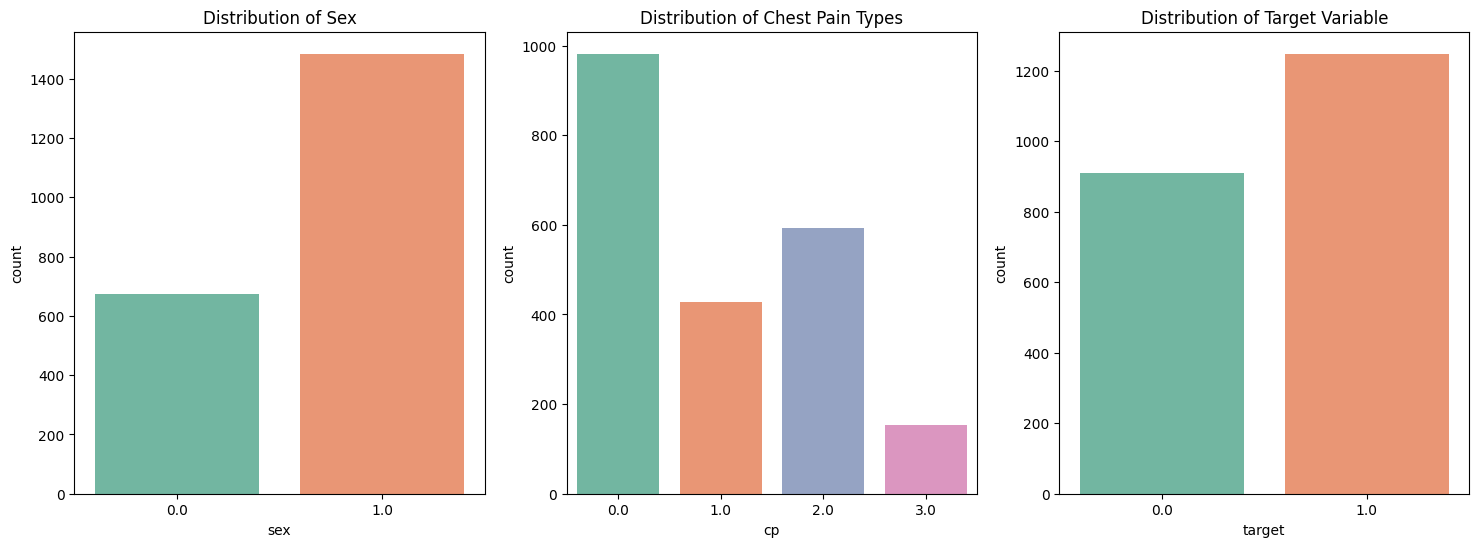

In [12]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.countplot(x='sex', data=df_cleaned, palette='Set2')
plt.title('Distribution of Sex')

plt.subplot(1, 3, 2)
sns.countplot(x='cp', data=df_cleaned, palette='Set2')
plt.title('Distribution of Chest Pain Types')

plt.subplot(1, 3, 3)
sns.countplot(x='target', data=df_cleaned, palette='Set2')
plt.title('Distribution of Target Variable')
plt.show()


Line Plot

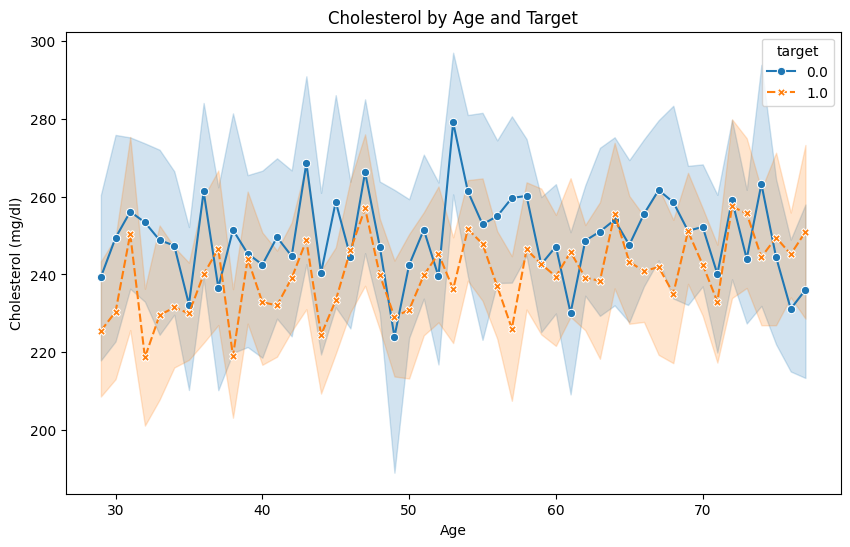

In [13]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='age', y='chol', hue='target', style='target', markers=True)
plt.title('Cholesterol by Age and Target')
plt.xlabel('Age')
plt.ylabel('Cholesterol (mg/dl)')
plt.show()


Geospatial visualization

In [14]:

data['latitude'] = np.random.uniform(low=22, high=30, size=len(df_cleaned))
data['longitude'] = np.random.uniform(low=70, high=80, size=len(df_cleaned))

fig = px.scatter_geo(data, lat='latitude', lon='longitude', color='target',
                     title="Geospatial Distribution of Heart Disease by Target",
                     color_continuous_scale=px.colors.sequential.Plasma)
fig.update_geos(projection_type="natural earth")
fig.show()

# **EDA**

Distribution of variables

<Figure size 1500x1000 with 0 Axes>

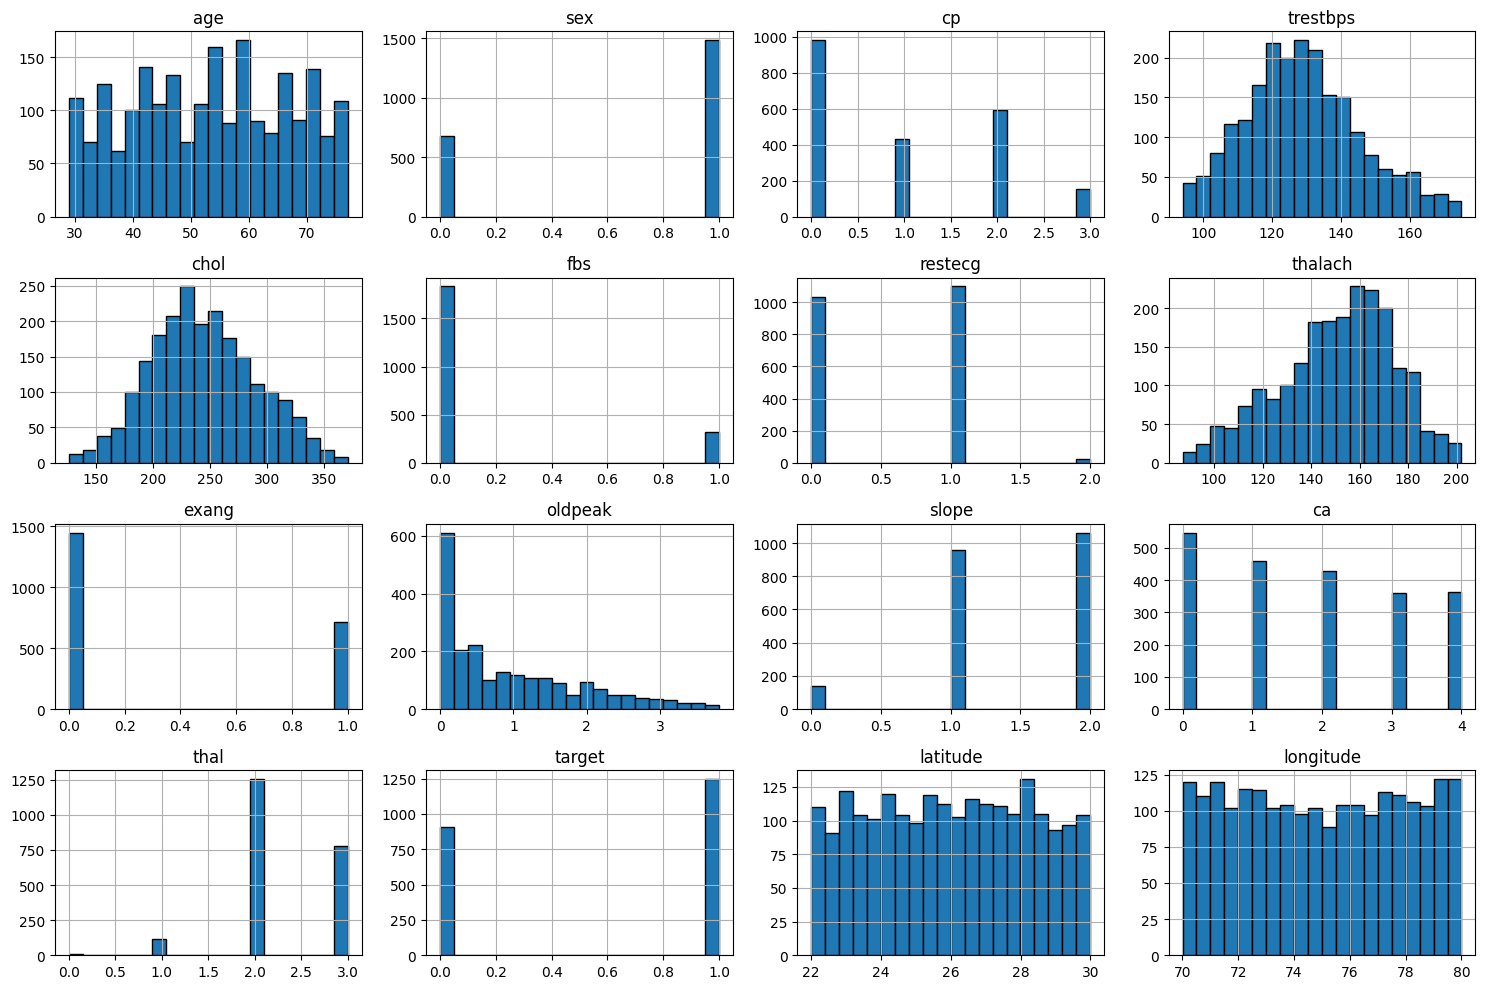

In [15]:
plt.figure(figsize=(15, 10))
data.hist(bins=20, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.show()


Correlation heatmap

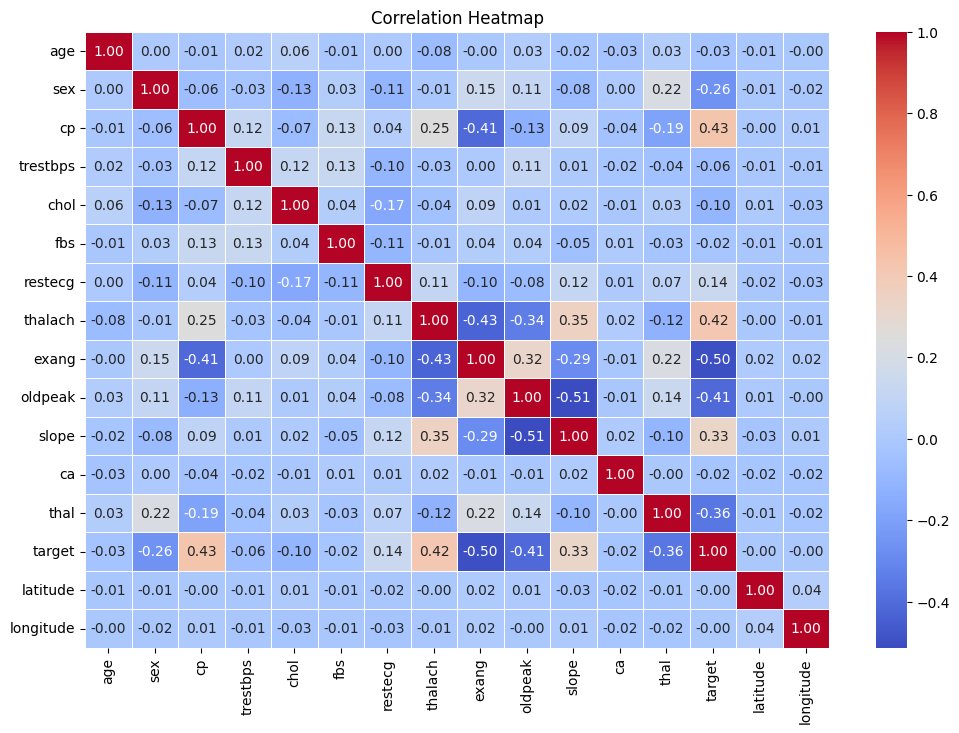

In [16]:

plt.figure(figsize=(12, 8))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Pair plot for key variables

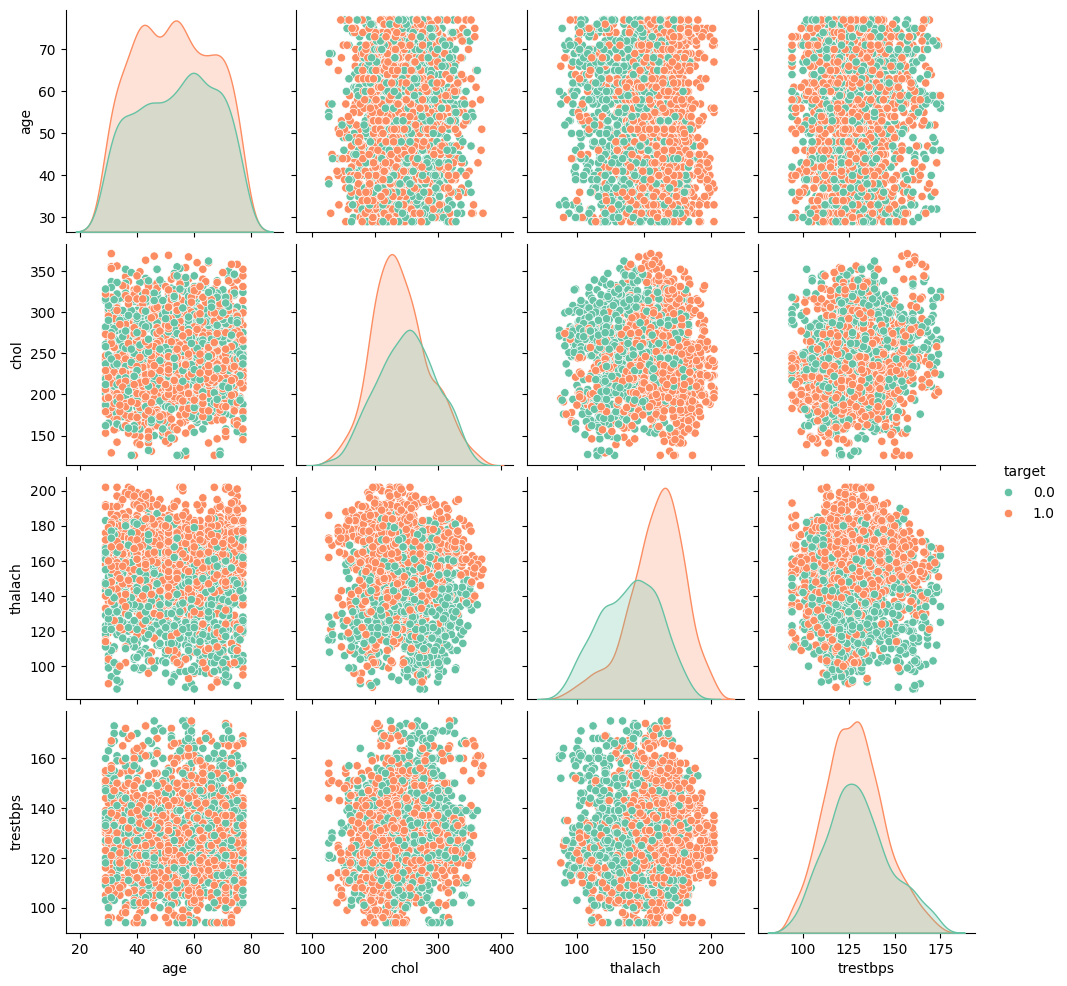

In [17]:

key_variables = ['age', 'chol', 'thalach', 'trestbps', 'target']
sns.pairplot(data[key_variables], hue='target', palette='Set2')
plt.show()

Checking for class imbalance in the target variable

<ipython-input-18-cd2e6d924b1b>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




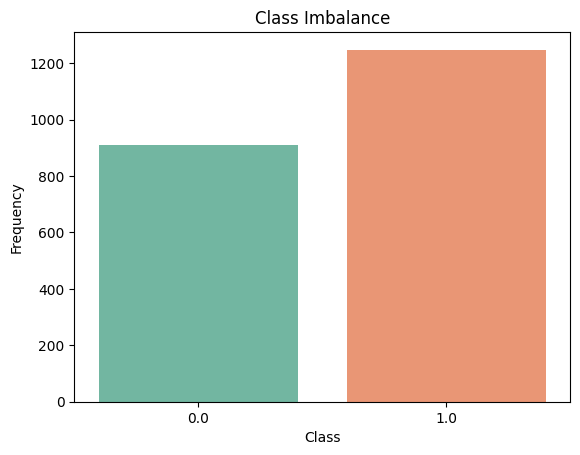

In [18]:
class_count = data['target'].value_counts()
sns.barplot(x=class_count.index, y=class_count.values, palette='Set2')
plt.title("Class Imbalance")
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

Summary statistics of numerical features


In [19]:
numerical_summary = data.describe()
print(numerical_summary)

               age          sex           cp     trestbps         chol  \
count  2158.000000  2158.000000  2158.000000  2158.000000  2158.000000   
mean     53.248378     0.687674     0.962465   129.130677   244.262743   
std      13.523017     0.463549     1.007151    16.594221    46.050908   
min      29.000000     0.000000     0.000000    94.000000   126.000000   
25%      42.000000     0.000000     0.000000   118.000000   211.000000   
50%      53.000000     1.000000     1.000000   128.000000   242.000000   
75%      65.000000     1.000000     2.000000   140.000000   275.000000   
max      77.000000     1.000000     3.000000   175.000000   371.000000   

               fbs      restecg      thalach        exang      oldpeak  \
count  2158.000000  2158.000000  2158.000000  2158.000000  2158.000000   
mean      0.150602     0.533364   150.454588     0.329935     0.949259   
std       0.357744     0.522599    23.420043     0.470298     0.962899   
min       0.000000     0.000000    87

# **Model Buiding**

In [20]:
data['target'].value_counts(normalize=True)

target
1.0    0.578313
0.0    0.421687
Name: proportion, dtype: float64

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2158 entries, 0 to 2157
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        2158 non-null   int64  
 1   sex        2158 non-null   float64
 2   cp         2158 non-null   float64
 3   trestbps   2158 non-null   int64  
 4   chol       2158 non-null   int64  
 5   fbs        2158 non-null   float64
 6   restecg    2158 non-null   float64
 7   thalach    2158 non-null   int64  
 8   exang      2158 non-null   float64
 9   oldpeak    2158 non-null   float64
 10  slope      2158 non-null   float64
 11  ca         2158 non-null   float64
 12  thal       2158 non-null   float64
 13  target     2158 non-null   float64
 14  latitude   2158 non-null   float64
 15  longitude  2158 non-null   float64
dtypes: float64(12), int64(4)
memory usage: 269.9 KB


Separate the target variable in the training set & test set

In [22]:
X = data.drop(['target'], axis=1)
y = data['target']

Train Test Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((1726, 15), (432, 15))

In [47]:

%%time

xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_train, y_train)


CPU times: user 175 ms, sys: 32.7 ms, total: 208 ms
Wall time: 187 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=33, ...)

In [48]:
xgb_predictions = xgb.predict(X_test)

Predicting y_pred using Random Forest Classifier

In [63]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

y_pred_xbg = xgb.predict(X_test)


Matrics Calculation

In [65]:
#Accuracy
accuracy_xbg = accuracy_score(y_test, y_pred_xbg)
print(f"XGB - Accuracy: {accuracy_xbg:.4f}")

# F1 Score
f1_xbg = f1_score(y_test, y_pred_xbg)
print(f"XGB - F1 Score: {f1_xbg:.4f}")

precision_xbg = precision_score(y_test, y_pred_xbg)
print(f"XGB - Precision: {precision_xbg:.4f}")

# Recall Score
recall_xbg = recall_score(y_test, y_pred_xbg)
print(f"XGB - Recall: {recall_xbg:.4f}")

XGB - Accuracy: 0.9468
XGB - F1 Score: 0.9535
XGB - Precision: 0.9440
XGB - Recall: 0.9633


Predicting y_pred using Random Forest Classifier

In [24]:
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)

y_pred_rf = RF.predict(X_test)



Metrics Calculation

In [25]:
#Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest - Accuracy: {accuracy_rf:.4f}")

# F1 Score
f1_rf = f1_score(y_test, y_pred_rf)
print(f"Random Forest - F1 Score: {f1_rf:.4f}")

precision_rf = precision_score(y_test, y_pred_rf)
print(f"Randon Forest - Precision: {precision_rf:.4f}")

# Recall Score
recall_rf = recall_score(y_test, y_pred_rf)
print(f"Random Forest - Recall: {recall_rf:.4f}")



Random Forest - Accuracy: 0.9375
Random Forest - F1 Score: 0.9459
Randon Forest - Precision: 0.9291
Random Forest - Recall: 0.9633


Predicting y_pred using Linear Regression

In [26]:
lr = LogisticRegression(max_iter=1500)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

Matrics Calculations


In [27]:
#Accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression - Accuracy: {accuracy_lr:.4f}")

# F1 Score
f1_lr = f1_score(y_test, y_pred_lr)
print(f"Logistic Regression - F1 Score: {f1_lr:.4f}")

precision_lr = precision_score(y_test, y_pred_lr)
print(f"Logistic Regression - Precision: {precision_lr:.4f}")

# Recall Score
recall_lr = recall_score(y_test, y_pred_lr)
print(f"Logistic Regression - Recall: {recall_lr:.4f}")



Logistic Regression - Accuracy: 0.8287
Logistic Regression - F1 Score: 0.8555
Logistic Regression - Precision: 0.8202
Logistic Regression - Recall: 0.8939


Predicting y_pred using DecisionTreeClassifier

In [28]:
clf = DecisionTreeClassifier()

clf = clf.fit(X_train,y_train)

y_pred_clf = clf.predict(X_test)

Matrics calculation

In [29]:
#Accuracy
accuracy_clf = accuracy_score(y_test, y_pred_clf)
print(f"Decision Tree classifer - Accuracy: {accuracy_clf:.4f}")

# F1 Score
f1_clf = f1_score(y_test, y_pred_clf)
print(f"Decision Tree classifer - F1 Score: {f1_clf:.4f}")

precision_clf = precision_score(y_test, y_pred_clf)
print(f"Decision Tree classifer - Precision: {precision_clf:.4f}")

# Recall Score
recall_clf = recall_score(y_test, y_pred_clf)
print(f"Decision Tree classifer - Recall: {recall_clf:.4f}")



Decision Tree classifer - Accuracy: 0.9352
Decision Tree classifer - F1 Score: 0.9438
Decision Tree classifer - Precision: 0.9289
Decision Tree classifer - Recall: 0.9592


Performance Comparision Graph of all the models

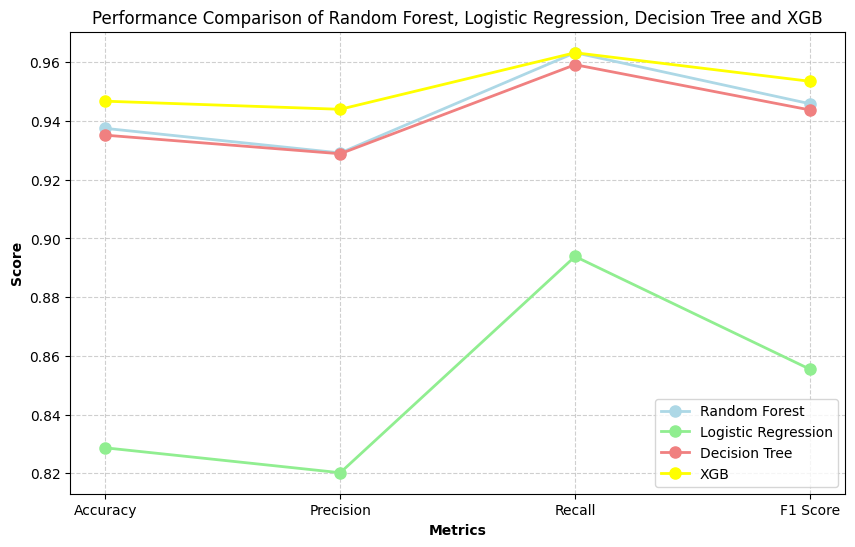

In [74]:
import matplotlib.pyplot as plt
import numpy as np

metrics_rf = [accuracy_rf, precision_rf, recall_rf, f1_rf]

metrics_lr = [accuracy_lr, precision_lr, recall_lr, f1_lr]

metrics_clf = [accuracy_clf, precision_clf, recall_clf, f1_clf]

metrics_xgb = [accuracy_xbg, precision_xbg, recall_xbg, f1_xbg]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics))

plt.figure(figsize=(10, 6))

plt.plot(x, metrics_rf, marker='o', linestyle='-', color='lightblue', label='Random Forest', linewidth=2, markersize=8)
plt.plot(x, metrics_lr, marker='o', linestyle='-', color='lightgreen', label='Logistic Regression', linewidth=2, markersize=8)
plt.plot(x, metrics_clf, marker='o', linestyle='-', color='lightcoral', label='Decision Tree', linewidth=2, markersize=8)
plt.plot(x, metrics_xgb, marker='o', linestyle='-', color='yellow', label='XGB', linewidth=2, markersize=8)

plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.xticks(x, metrics)
plt.title('Performance Comparison of Random Forest, Logistic Regression, Decision Tree and XGB')

plt.legend()

plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


Confusion Matrix predictions of Logistic Regression



In [31]:
test_preds= lr.predict(X_test)
cm_lr=confusion_matrix(y_test, test_preds)

Confusion Matrix of Logistic Regression

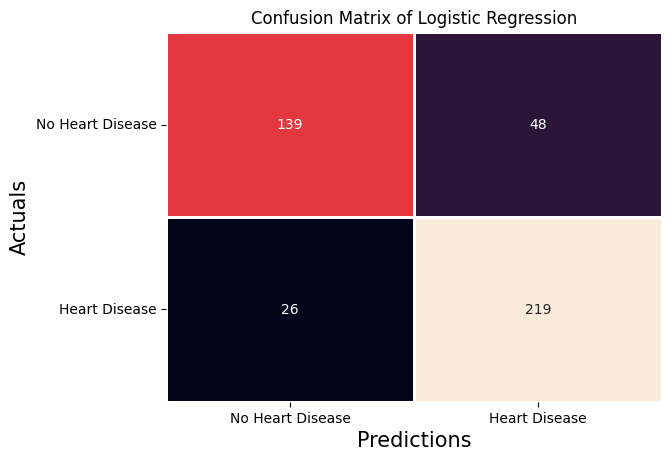

In [32]:
ax = plt.subplot()
sns.heatmap(cm_lr, annot=True, fmt="d", ax=ax, linewidths=1, cbar=False)  # Use fmt="d" for integer format
ax.set_title('Confusion Matrix of Logistic Regression')
ax.set_xlabel('Predictions', fontsize=15)
ax.set_ylabel('Actuals', fontsize=15)
ax.xaxis.set_ticklabels(['No Heart Disease', 'Heart Disease'])
ax.yaxis.set_ticklabels(['No Heart Disease', 'Heart Disease'], rotation=0, fontsize=10)
plt.show()

Confusion Matrix predictions of XGB Classifier



In [67]:
test_preds= xgb.predict(X_test)
cm_xgb=confusion_matrix(y_test, test_preds)

Confusion Matrix of XGB Classifier

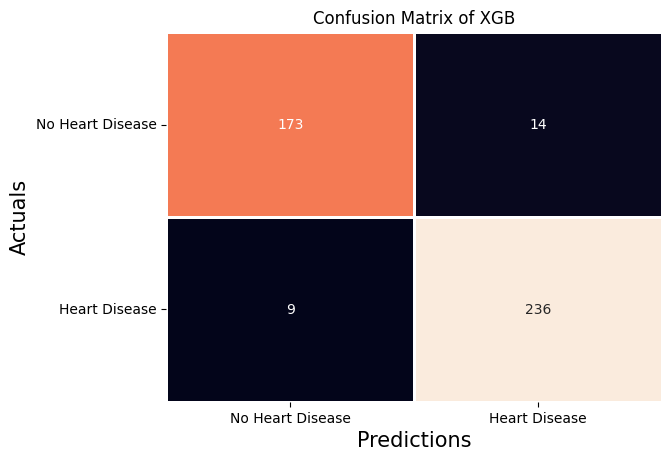

In [68]:
ax= plt.subplot()
sns.heatmap(cm_xgb, annot=True,fmt="d", ax=ax, linewidths=1, cbar=False)
ax.set_title('Confusion Matrix of XGB')
ax.set_xlabel('Predictions', fontsize = 15)
ax.set_ylabel('Actuals', fontsize = 15)
ax.xaxis.set_ticklabels(['No Heart Disease', 'Heart Disease'])
ax.yaxis.set_ticklabels(['No Heart Disease', 'Heart Disease'], rotation = 0, fontsize = 10);

# **LIME Tabular Explainer for explaining XGB predictions**

In [70]:
explainer = lime_tabular.LimeTabularExplainer(
 training_data=np.array(X_train),
 feature_names=X_train.columns,
 class_names=['No Heart Disease', 'Heart Disease'],
 mode='classification'
)

Choosing one patient from X_test

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ 

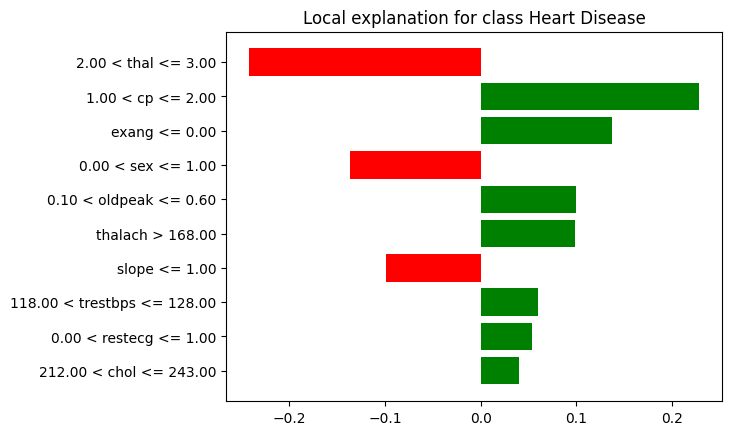

In [71]:
i=22
exp = explainer.explain_instance(
 data_row = X_test.iloc[i],
 predict_fn=xgb.predict_proba
)
fig = exp.as_pyplot_figure()
plt.show()


In [72]:
exp.show_in_notebook(show_table=True)

# True Label of the patient

In [73]:
y_test.iloc[22]

1.0

In [40]:
pip install shap

In [39]:

import shap


shap.initjs()

In [49]:

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

In [50]:
X_shap = pd.DataFrame(shap_values)
X_shap.head()

0         1         2         3         4         5         6   \
0 -0.100056 -0.568607 -2.491959 -0.001644 -1.198580  0.050304 -0.629683   
1 -0.499017 -0.157610 -3.395136  0.663244 -0.538568 -0.002169 -0.746741   
2 -0.031407  1.689928  1.458744 -0.039882 -1.258573  0.251272  0.387319   
3 -0.783194  0.355709  0.364926  0.272126 -1.847554 -1.279447 -0.978612   
4 -0.271625  1.045602 -2.661446 -1.524755 -0.704590  0.042273 -0.064237   

         7         8         9         10        11        12        13  \
0 -0.865802 -1.608180  0.969061 -0.229552  0.080190  0.628414 -0.116062   
1  0.306795  0.230327  0.661329  0.457505  0.275195 -2.480143  0.274365   
2 -0.090620  0.369762  1.397941  0.985984 -0.236253  1.453956 -0.381457   
3 -0.240744  0.058798 -0.137493  0.464016 -0.054322  0.945823 -0.163664   
4  0.043152 -1.600402  1.253343 -0.572184 -0.119848  1.687139  0.199251   

         14  
0 -0.040470  
1 -0.180139  
2 -0.145293  
3 -0.267213  
4 -0.364740

In [51]:
print('Expected Value: ', explainer.expected_value)

Expected Value:  0.3884127


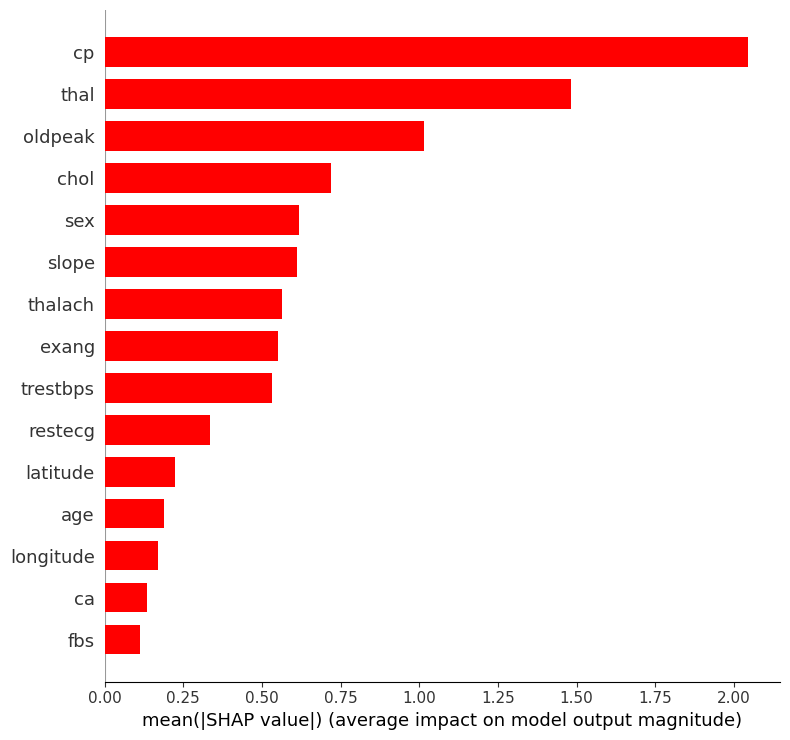

In [52]:
shap.summary_plot(shap_values, X_test, plot_type="bar", color='red')

In [60]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [54]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[6,:], X_test.iloc[6,:])

In [55]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[15,:], X_test.iloc[15,:])

In [56]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test.iloc[:1000,:])

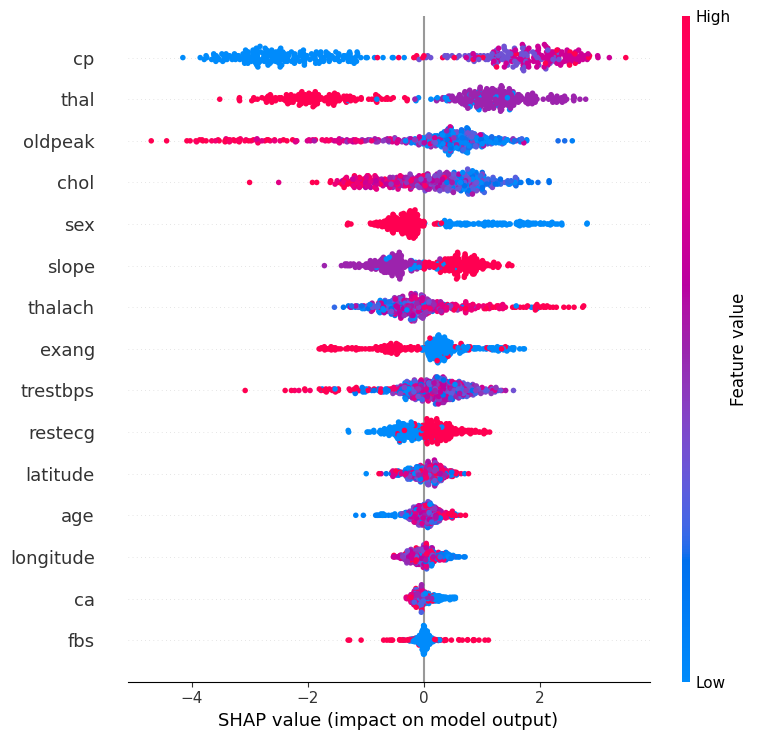

In [57]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

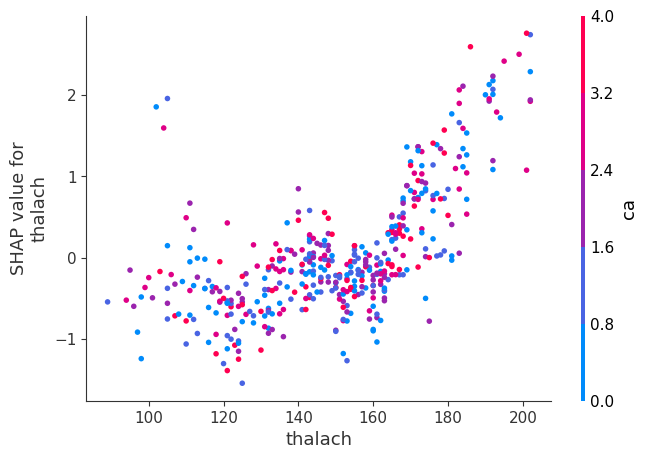

In [58]:
shap.initjs()
shap.dependence_plot(ind='thalach', interaction_index='ca',
                     shap_values=shap_values,
                     features=X_test,
                     display_features=X_test)